# Class attention on random inputs, multibatch
## FROZEN, DO NOT MODIFY

Same as `02_random_model.ipynb`, but now with multiple batches

In [19]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
def detorch(x):
    return x.detach().cpu().numpy()

In [14]:
input_size = 7
hidden_size = 11
n_classes = 5
batch_size = 5

In [15]:

class ClassAttentionModel(nn.Module):
    def __init__(self,):
        super().__init__()

        self.x_enc = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

        self.c_enc = nn.Embedding(n_classes, hidden_size)

    def forward(self, x, c):
        h_x = self.x_enc(x)
        h_c = self.c_enc(c)
        
        logits = h_x @ h_c.T

        return logits


class ClassAttentionWNet(nn.Module):
    def __init__(self,):
        super().__init__()

        self.x_enc = nn.Sequential(nn.Linear(input_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

        self.c_enc = nn.Sequential(nn.Embedding(n_classes, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, hidden_size))

    def forward(self, x, c):
        h_x = self.x_enc(x)
        h_c = self.c_enc(c)
        
        logits = h_x @ h_c.T

        return logits



In [16]:
possible_labels = [f'Class {str(i)}' for i in range(n_classes)]
label2c = {possible_labels[i]: i for i in range(len(possible_labels))}
c = torch.LongTensor([label2c[l] for l in possible_labels])

print("Possible labels: ", possible_labels)
print("Label2c        : ", label2c)
print("c              : ", c)

Possible labels:  ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
Label2c        :  {'Class 0': 0, 'Class 1': 1, 'Class 2': 2, 'Class 3': 3, 'Class 4': 4}
c              :  tensor([0, 1, 2, 3, 4])


## Two batches

In [17]:
n_batches = 2

xs = [torch.randn([batch_size, input_size]) for _ in range(n_batches)]

y_strs = [random.choices(possible_labels, k=batch_size) for _ in range(n_batches)]
# y != f(y_str),
# y == f(y_str, possible_classes, batch)
ys = [torch.LongTensor([label2c[s] for s in y_str]) for y_str in y_strs]


print("X: ", xs)
print("Labels         : ", y_strs)
print("Labels Tensor  : ", ys)

X:  [tensor([[-0.3268, -0.6987, -0.7536, -0.7025,  0.5838,  0.7090, -0.3372],
        [ 0.8319, -0.1393, -0.4443, -1.5168,  2.2508,  0.3853,  0.5634],
        [-1.2892,  0.9209,  1.4465, -0.2462,  0.3336, -1.5688, -0.2925],
        [-0.5761,  2.0432, -0.3994,  0.8740,  1.4812, -1.8933,  1.2436],
        [ 0.5900, -0.1327, -0.8275,  1.1390, -0.0976, -0.8444,  0.9001]]), tensor([[-2.2890, -0.0473, -0.4151, -1.1469,  0.1377, -0.5843,  0.0974],
        [-0.9918,  0.2942, -0.6511,  0.1985,  1.5275,  0.6463, -0.3871],
        [-0.0928, -1.0577,  2.1610,  1.0595,  0.8058, -1.2605, -0.9218],
        [-0.6854,  1.3127, -0.7749,  0.0586, -1.0749,  1.4801, -1.2496],
        [ 1.0310, -1.7005, -0.7979, -0.4462, -2.3524,  1.2924,  0.8243]])]
Labels         :  [['Class 4', 'Class 4', 'Class 3', 'Class 3', 'Class 2'], ['Class 1', 'Class 3', 'Class 3', 'Class 2', 'Class 3']]
Labels Tensor  :  [tensor([4, 4, 3, 3, 2]), tensor([1, 3, 3, 2, 3])]


## Train class attention with class embeddings

Text(0.5, 1.0, 'Accuracy')

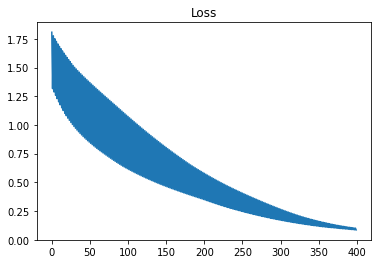

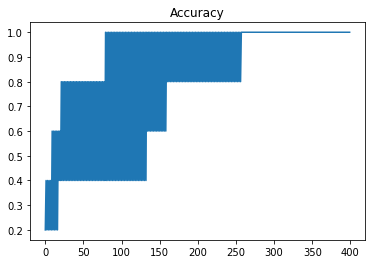

In [20]:
loss_hist = []
acc_hist = []

model = ClassAttentionModel()
optimizer = torch.optim.Adam(model.parameters())


for _ in tqdm(range(200)):
    for x, y in zip(xs, ys):
        optimizer.zero_grad()

        logits = model(x, c)

        loss = F.cross_entropy(logits, y)

        _, preds = logits.max(-1)
        acc = torch.sum(preds == y).float() / x.shape[0]

        acc_hist.append(detorch(acc))
        loss_hist.append(detorch(loss))

        loss.backward()
        optimizer.step()


plt.figure()
plt.plot(loss_hist)
plt.title('Loss')

plt.figure()
plt.plot(acc_hist)
plt.title('Accuracy')

## Train class attention with a classs network

Text(0.5, 1.0, 'Accuracy')

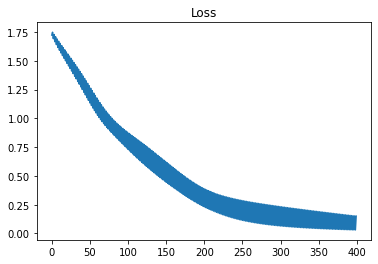

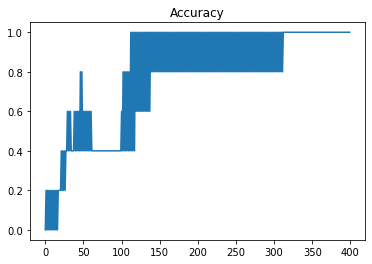

In [21]:
loss_hist = []
acc_hist = []

model = ClassAttentionWNet()
optimizer = torch.optim.Adam(model.parameters())


for _ in tqdm(range(200)):
    for x, y in zip(xs, ys):
        optimizer.zero_grad()

        logits = model(x, c)

        loss = F.cross_entropy(logits, y)

        _, preds = logits.max(-1)
        acc = torch.sum(preds == y).float() / x.shape[0]

        acc_hist.append(detorch(acc))
        loss_hist.append(detorch(loss))

        loss.backward()
        optimizer.step()


plt.figure()
plt.plot(loss_hist)
plt.title('Loss')

plt.figure()
plt.plot(acc_hist)
plt.title('Accuracy')